In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import pandas as pd
import yaml
import geopandas as gp
import time
import pandas as pd
from ccfj import CC
from ccfj import GetStationPairs
from geopy.distance import great_circle
import folium
import h5py

In [48]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [49]:
with open('a-project.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project/output_FJSJ_16-01/'               # Harmon server
name_project

'project/output_FJSJ_v9.1_test/'

In [50]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = dir_project_workspace + name_project
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project/output_FJSJ_v9.1_test/


In [51]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [52]:
dir_CC = dir_CC_workspace + info_basic['name_CC']
dir_ds = dir_project + info_basic['dir_ds']
dir_partition = dir_project + info_basic['dir_partition']
dir_image = dir_project + info_basic['dir_image'] + 'regular_FJ/'
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [53]:
key_subworks = info_basic['key_subworks']
key_subworks = ['07-03']
key_subworks

['07-03']

### read all stations coordinates

In [54]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [55]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [56]:
ncffile = h5py.File(dir_CC + 'gather_all.h5','r')
ncfs = ncffile['ncfs'][:]
f = ncffile['f'][:]
count_all = ncffile['count'][:]
ncffile.close()

In [57]:
stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [58]:
def Pairs(sta):
    p = []
    nsta = len(sta)
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            p.append([sta[ii],sta[jj]])
    return p
def cal_indx(pair,nsta):
    indx = int(pair[0]*(2*nsta-pair[0]-1)/2+pair[1]-pair[0]-1)
    return indx

In [59]:
def time_window_filter(t,ncfst0,r,v_min,t0,a):
    ncfst = ncfst0.copy()
    for i in range(len(ncfst)):
        tag = r[i]/v_min
        #print(t0,tag)
        t1 = t[t>-tag-t0][t[t>-tag-t0]< tag+t0]
        start = np.where(t == t1[0])[0][0]
        end = np.where(t == t1[-1])[0][0]
        ncfst[i][start:end+1]= ncfst[i][start:end+1]* np.exp(-a*np.abs((tag-np.abs(t1))))
    return ncfst

In [60]:
def linear_stack(key_subwork):
    global dir_project
    global key_subworks
    global info_basic
    global flag_save

    start0 = time.time()
    path_partition= dir_partition + str(key_subwork) + '.txt'
    stalist, lat_stations, lon_stations = np.loadtxt(path_partition, dtype='str', unpack=True)
    nsta = len(stalist)
    StationPairs = GetStationPairs(nsta)
    nPairs = int(len(StationPairs)/2)
    nf = info_basic['nf']
    ncfs_sum_linear = np.zeros((nPairs,nf),dtype=np.complex64)
    r = np.zeros(nPairs)
    f0 = info_basic_bi['f']
    count= np.zeros(nPairs)
    StationPairs = GetStationPairs(nsta)
    for i in range(nPairs):
        sta1 = StationPairs[2*i]
        sta2 = StationPairs[2*i+1]
        idx1 = np.min( [int(stalist_all.index(stalist[sta1])),int(stalist_all.index(stalist[sta2]))] )
        idx2 = np.max( [int(stalist_all.index(stalist[sta1])),int(stalist_all.index(stalist[sta2]))] )
        
        m = 0
        for j in range(nsta_all-idx1,nsta_all):
            m += j
        num = m +idx2 - idx1 -1
        
        ncfs_sum_linear[i,:] = np.nan_to_num(ncfs[num,:])
        count[i] = count_all[num]
        r[i] = great_circle((lat_stations[sta1],lon_stations[sta1]),(lat_stations[sta2],lon_stations[sta2])).km
    if flag_save:
        tag = name_project[ name_project.rfind('_')+1: -1]
        dir_stack = dir_project + 'stack_'+tag+'/'
        if not os.path.exists(dir_stack):
            os.makedirs(dir_stack)
        info_basic['dir_stack'] = dir_stack
        outname = key_subwork+'_gather_linear.h5'
        if os.path.exists(dir_stack+outname):
            os.remove(dir_stack+outname)
        ncffile = h5py.File(dir_stack+outname,'w')
        ncffile.create_dataset('ncfs', data=ncfs_sum_linear) 
        ncffile.create_dataset('r',data=r)
        ncffile.create_dataset('count',data=count)
        ncffile.create_dataset('f',data=f0)
        ncffile.create_dataset('StationPairs',data=StationPairs)
        ncffile.close()
    print('Finish linear stack, time:', time.time()-start0, ' seconds')
    return ncfs_sum_linear, r, StationPairs

In [61]:
def remove_stack(key_subwork,ncfs_sum_linear,r,StationPairs):
    global dir_project
    global key_subworks
    global info_basic
    global flag_save
    global v_tag
    global t0
    global a

    start0 = time.time()
    f0 = info_basic_bi['f']
    dt = 1/np.max(f0)
    t = (np.linspace(-len(f0)-1,len(f0)-1,2*(len(f0)-1))+0.5)*dt/2
    ncfst_linear = mathlib.freq_time(ncfs_sum_linear)
    ncfst1 = time_window_filter(t,ncfst_linear,r,v_tag,t0,a)
    ncfs_sum_remove = mathlib.time_freq(ncfst1)
    if flag_save:
        tag = name_project[ name_project.rfind('_')+1: -1]
        dir_stack = dir_project + 'stack_'+tag+'/'
        outname = key_subwork+'_gather_timewindow.h5'
        if os.path.exists(dir_stack+outname):
            os.remove(dir_stack+outname)
        ncffile = h5py.File(dir_stack+outname,'w')
        ncffile.create_dataset('ncfs', data=ncfs_sum_remove) 
        ncffile.create_dataset('r',data=r)
        ncffile.create_dataset('StationPairs',data=StationPairs)
        ncffile.close()
    print('Finish remove stack, time:', time.time()-start0, ' seconds')
    return ncfs_sum_remove

In [62]:
v_tag = info_basic['v_tag']
t0 = info_basic['t0']
a = info_basic['a']

In [63]:
flag_save = 0

start = 0 
interval = 10
flag_time = 0.02
tao = 0

c_map = 'jet'
v_min = 0.1
v_max = None
d_len = 31

xlim_f = [2,30]
xlim_T = [-1,1]

info_basic['v_min'] = v_min
info_basic['v_max'] = v_max
info_basic['c_map'] = c_map

07-03; 1/1 subworks.
Finish linear stack, time: 0.06575298309326172  seconds
Finish remove stack, time: 0.030140399932861328  seconds


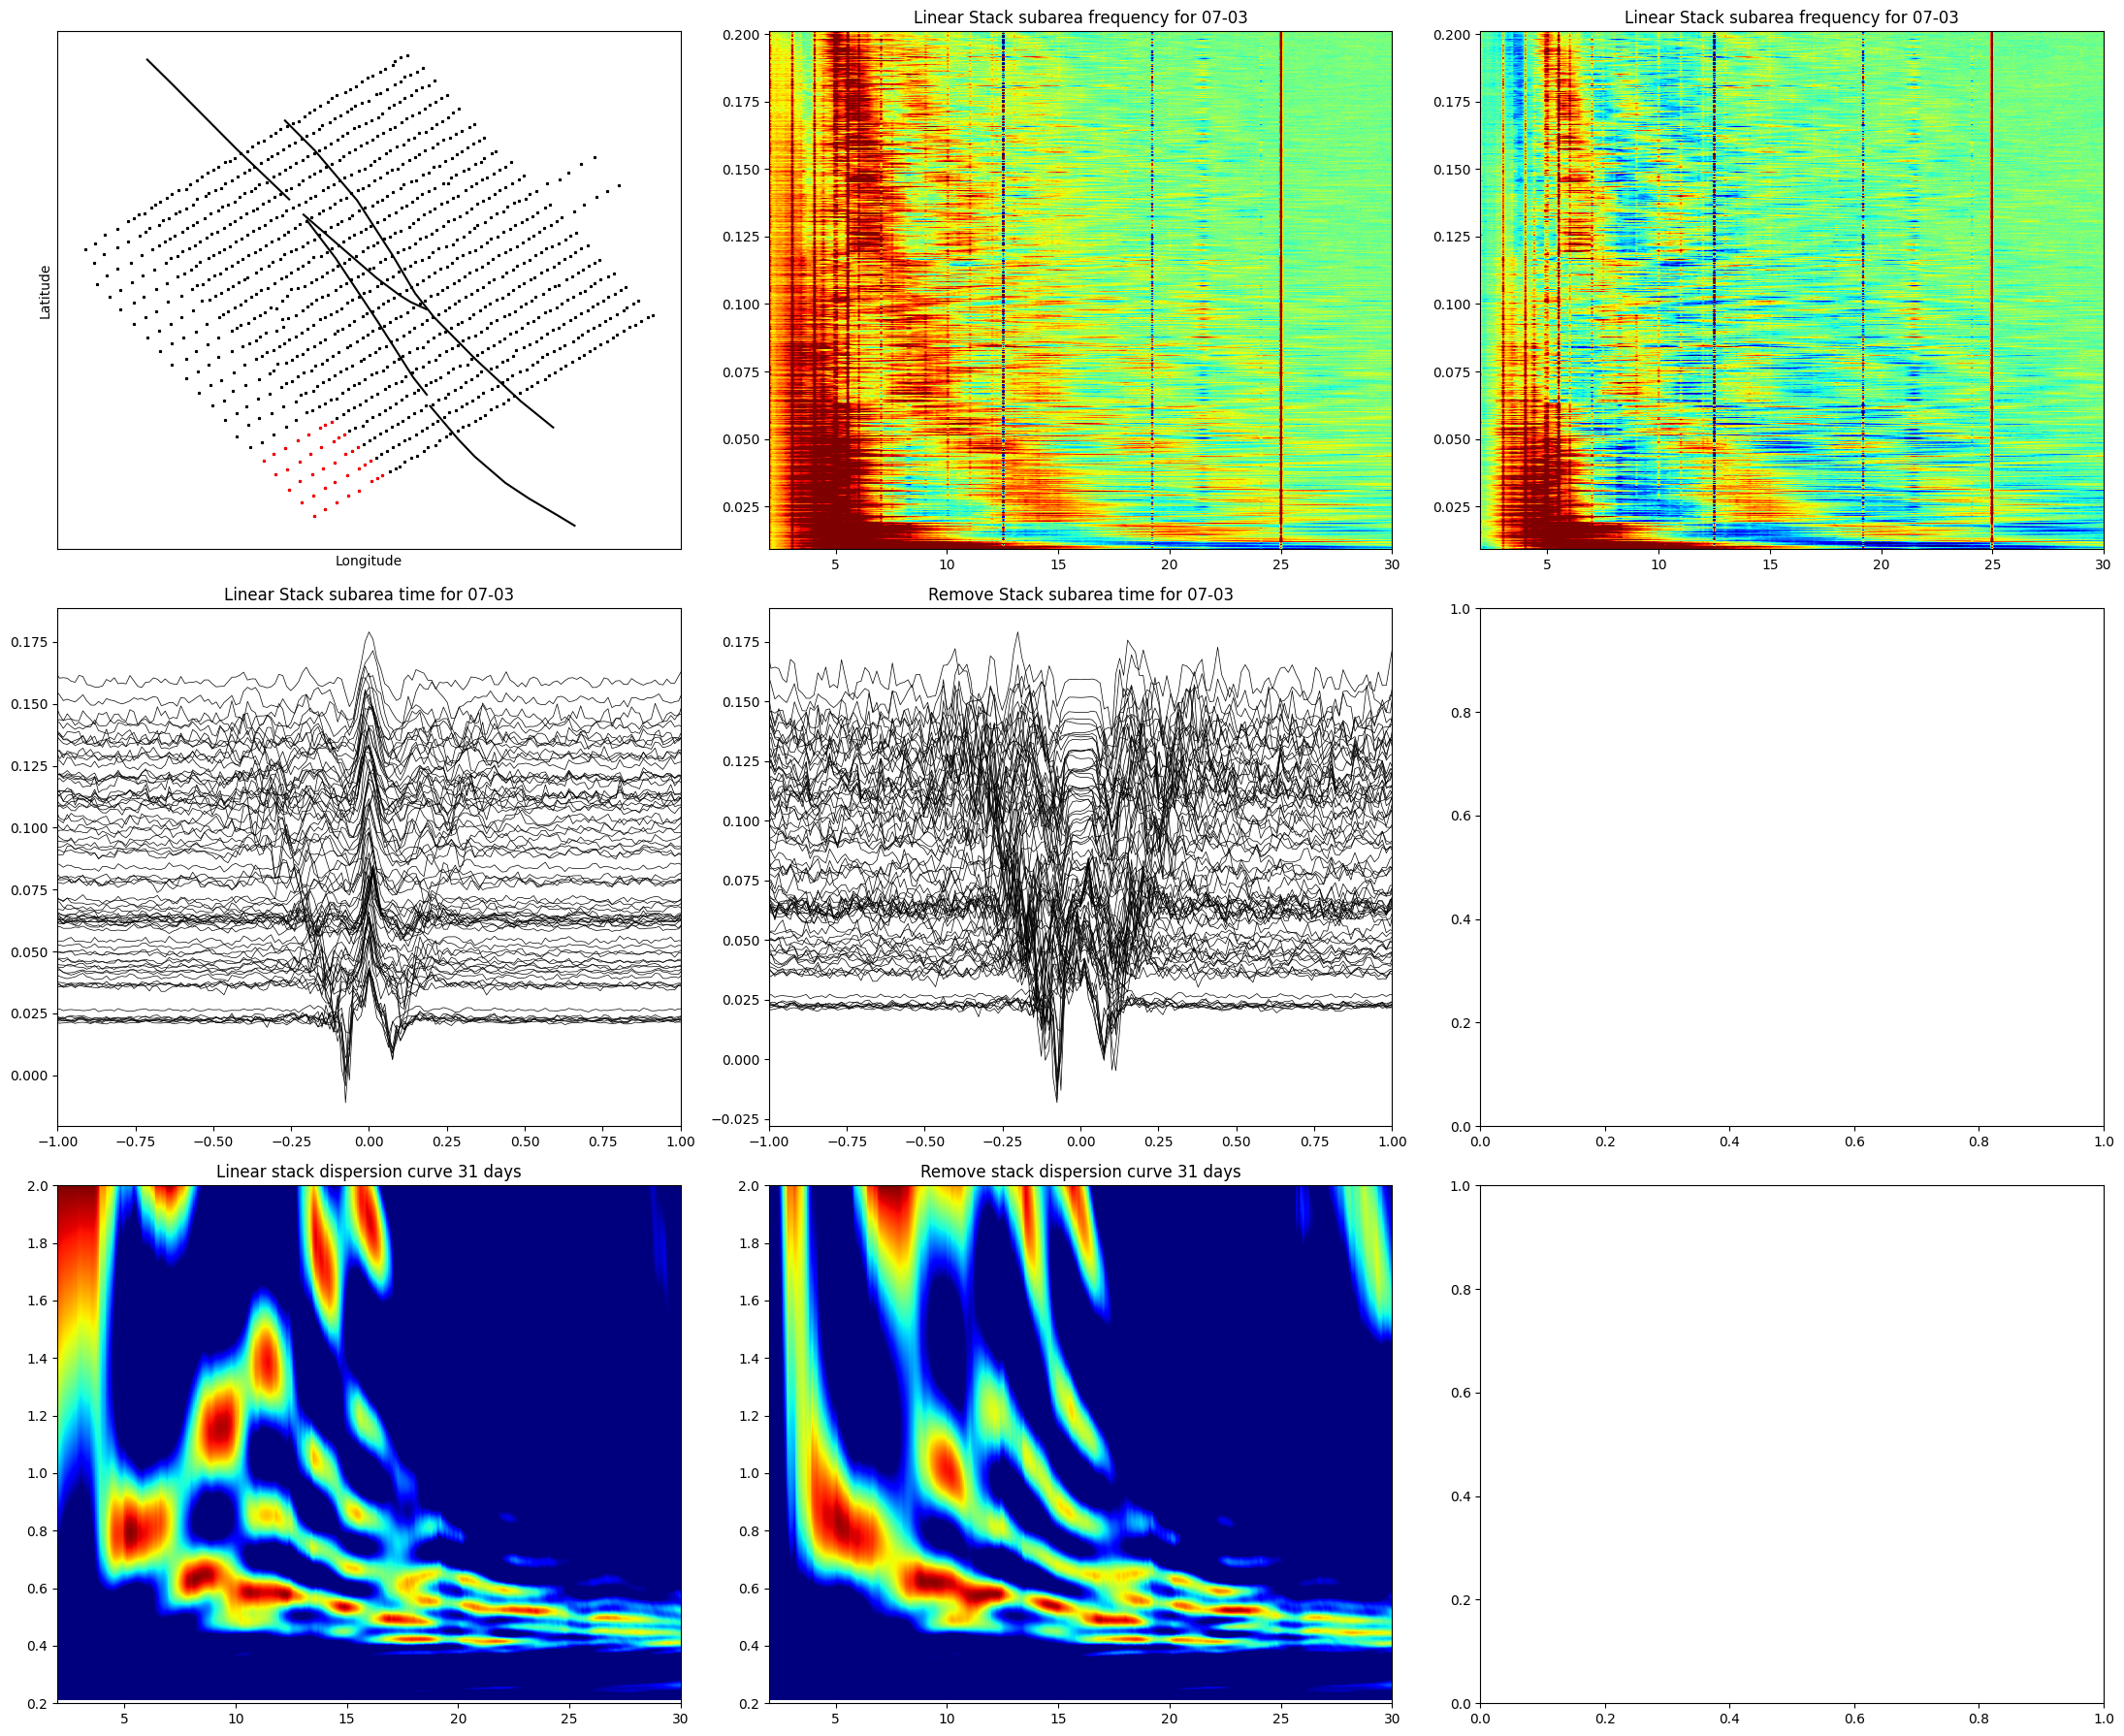

In [64]:
for key_subwork in key_subworks:
    print(key_subwork+ '; '+str(key_subworks.index(key_subwork)+1)+'/'+str(len(key_subworks))+' subworks.')
    ncfs_sum_linear, r, StationPairs = linear_stack(key_subwork)
    ncfs_sum_remove = remove_stack(key_subwork,ncfs_sum_linear,r,StationPairs)
    
    fig,ax = plt.subplots(3,3,figsize= (22,18))
    # plot area
    stalist = stations[key_subwork]
    lat = lat[key_subwork].astype(float)
    lon = lon[key_subwork].astype(float)
    nsta = len(stalist)
    StationPairs = GetStationPairs(nsta)
    nPairs = int(len(StationPairs)/2)

    ax[0][0]=plotlib.plot_area(ax[0][0],lon_all,lat_all,lon,lat)
    for i in range(len(faults)):
        ax[0][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
    

    # plot ncfs and ncfst
    # linear stack
    f0 = info_basic_bi['f']
    t = info_basic_bi['t']
    ncfst_linear = mathlib.freq_time(ncfs_sum_linear)
    ncfst_remove = mathlib.freq_time(ncfs_sum_remove)
    
    title1 = "Linear Stack subarea frequency for "+key_subwork
    #xlim_f = [0,15]
    ax[0][1] = plotlib.plot_ncfs(ax[0][1],f0,ncfs_sum_linear,r,title1,xlim_f,0)
    ax[0][2] = plotlib.plot_ncfs(ax[0][2],f0,ncfs_sum_remove,r,title1,xlim_f,0)
    
    # plot fj
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_linear = ds['ds_linear'][0]
    ds_remove = ds['ds_remove'][0]
    ds_linear = plotlib.smooth_ds(ds_linear)
    ds_remove = plotlib.smooth_ds(ds_remove)
    c = np.linspace(info_basic['c_min'],info_basic['c_max'],info_basic['c_num'])
    #c = np.linspace(100,2000,1000)
    title0 = "Linear Stack subarea time for "+key_subwork
    ax[1][0] = plotlib.plot_ncfst(ax[1][0],t,ncfst_linear[start::interval],r[start::interval],title0,flag_time,xlim_T,0)
    title0 = "Remove Stack subarea time for "+key_subwork
    ax[1][1] = plotlib.plot_ncfst(ax[1][1],t,ncfst_remove[start::interval],r[start::interval],title0,flag_time,xlim_T,0)
    for i in range(len(r)):
        ax[1][1].plot()


    
    title0 = "Linear stack dispersion curve "+str(d_len)+' days'
    ax[2][0] = plotlib.plot_fj(ax[2][0],ds_linear,title0,f0,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[2][0].set_xlim(xlim_f)

    title0 = "Remove stack dispersion curve "+str(d_len)+' days'
    ax[2][1] = plotlib.plot_fj(ax[2][1],ds_remove,title0,f,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[2][1].set_xlim(xlim_f)


    plt.tight_layout()
    plt.savefig(dir_image+key_subwork+'_compare_remove.png',dpi=100)
    plt.close()

In [65]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)